In [11]:
%matplotlib notebook

In [12]:
import numpy as np
from mayavi import mlab
from matplotlib import pyplot as plt
import ipywidgets as widgets
from importlib import reload

In [13]:
def widget_plot(e, phi=0):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect("equal")
    fig.tight_layout()
    
    def arr_plot(phi):
        ax.clear()
        ax.scatter(e[phi][0], e[phi][1], np.linspace(1,20, len(e[phi][0])), c="C0")
        ax.plot(e[phi][0], e[phi][1], lw=1, c="C0")
        ax.scatter(e[phi][0][0], e[phi][1][0], c="C1")
        ax.set_xlim(4.5,6.5)
        ax.set_ylim(-1.2,1.2)
    
    phi = widgets.IntSlider(min=0, max=e.shape[0]-1, value=0, step=1)
    widgets.interact(arr_plot, phi = phi)

In [15]:
#filename = "quad_island_edge_coords"
#filename = "triple_island_edge_coords"
#filename = "double_island_edge_coords"
#filename = "single_island_edge_coords"
filename = "outer_edge_coords"
eq_sp_coords = np.load(f"{filename}.npz")["data"]
e = eq_sp_coords

In [16]:
def min_dist_to_point(point, array):
    quadr_dist = (array[0] -  point[0])**2 + (array[1] -  point[1])**2
    return np.argmin(quadr_dist)

In [17]:
# pad e by one beforehand
e_pad = np.empty((e.shape[0]+1, 2, e.shape[2]))
e_pad[:-1] = e
e_pad[-1] = e_pad[0]
# find which indices you want to start the array with
start_indices = np.empty(e_pad.shape[0], dtype=int)
start_indices[0] = 0
for phi in range(e_pad.shape[0]-1):
    curr_point = e_pad[phi,:,start_indices[phi]]
    next_index =  min_dist_to_point(curr_point, e_pad[phi+1,:,:])
    start_indices[phi+1] = next_index

In [18]:
# create new array and paste ordered data into it
sorted_e = np.empty_like(e_pad)
sl = e_pad.shape[2]
for phi, si in zip(range(e_pad.shape[0]), start_indices):
    sorted_e[phi,:,:sl-si] = e_pad[phi, :, si:]
    sorted_e[phi,:,sl-si:] = e_pad[phi, :, :si]

In [19]:
# create new array to directly be meshable by using 
# the correct shape and padding the poloidal ends too, so that the triangulation wraps
# mesh_e[ choose xyz, go along toroidially, go along poloidially] = the x/y/z coordinate
mesh_e = np.empty((3, sorted_e.shape[0], sorted_e.shape[2]+1))

R, Z = sorted_e.transpose((1,0,2))
PHI = np.expand_dims(np.linspace(0, 2*np.pi, R.shape[0]), 1)
X, Y = R*np.cos(PHI), R*np.sin(PHI)

mesh_e[0,:,:-1] = X
mesh_e[1,:,:-1] = Y
mesh_e[2,:,:-1] = Z
# wrapping
mesh_e[:,:,-1] = mesh_e[:,:,0]

In [20]:
np.savez(f"{filename}_mesh.npz", data=mesh_e)

<IPython.core.display.Javascript object>


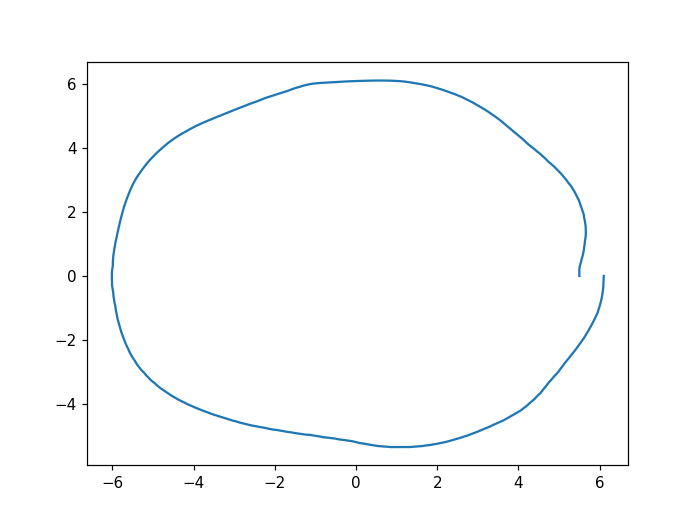

In [10]:
plt.close("all")
plt.plot(mesh_e[0,:,0], mesh_e[1,:,0])